In [10]:
import time

In [11]:
from rich import print
import dill as pickle

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

In [3]:
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

using cuda: NVIDIA GeForce RTX 3080

In [4]:
device

device(type='cuda')

In [5]:
class Classifier(nn.Module):

    def __init__(self, inodes, hnodes, onodes, learning_rate):
        # call the base class's initialisation too
        super().__init__()
        
        # dimensions
        self.inodes, self.hnodes, self.onodes = inodes, hnodes, onodes
        
        # learning rate
        self.lr = learning_rate
        
        # define the layers and their sizes, turn off bias
        self.linear_ih = nn.Linear(inodes, hnodes, bias=False)
        self.linear_ho = nn.Linear(hnodes, onodes, bias=False)
        
        # define activation function
        self.activation = nn.Sigmoid()
        # define inverse activation function
        self.inverse_activation_function = torch.logit
        
        # create error function
        # self.error_function = torch.nn.MSELoss(size_average=False)  # size_average is deprecated
        self.error_function = torch.nn.MSELoss(reduction='sum')

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), self.lr)

        # use GPU if it is available
        self.ftensor = torch.cuda.FloatTensor if device.type=='cuda' else torch.FloatTensor
            
    
    def forward(self, inputs_list):
        # convert list to a 2-D FloatTensor then wrap in Variable 
        inputs = Variable(self.ftensor(inputs_list).view(1, self.inodes))
            
        # combine input layer signals into hidden layer
        hidden_inputs = self.linear_ih(inputs)
        # apply sigmiod activation function
        hidden_outputs = self.activation(hidden_inputs)
        
        # combine hidden layer signals into output layer
        final_inputs = self.linear_ho(hidden_outputs)
        # apply sigmiod activation function
        final_outputs = self.activation(final_inputs)
        
        return final_outputs

    
    def train(self, inputs_list, targets_list):
        # calculate the output of the network
        output = self.forward(inputs_list)

        # create a Variable out of the target vector, doesn't need gradients calculated
        target_variable = Variable(self.ftensor(targets_list).view(1, self.onodes), requires_grad=False)
        
        # calculate error
        loss = self.error_function(output, target_variable)
        # print(loss.data[0])

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        
        
    def backquery(self, targets_list):
        """backquery the neural network."""
        def _scale(signal):
            # scale signal to 0.01 to 0.99
            signal -= signal.min().item()
            signal /= signal.max().item()
            signal *= 0.98
            signal += 0.01
            return signal
        
        # create a Variable out of the target vector, doesn't need gradients calculated
        target_variable = Variable(self.ftensor(targets_list).view(1, self.onodes), requires_grad=False).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(target_variable)
        # calculate the signal out of the hidden layer and scale them back to 0.01 to 0.99
        hidden_outputs = _scale(torch.matmul(self.linear_ho.weight.T, final_inputs))
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        # calculate the signal out of the input layer and scale them back to 0.01 to .99
        inputs = _scale(torch.matmul(self.linear_ih.weight.T, hidden_inputs))
        
        return inputs

In [28]:
# number of input, hidden and output nodes
input_nodes, hidden_nodes, output_nodes = 784, 200, 10

# learning rate
learning_rate = 0.1

# create instance of neural network
n = Classifier(input_nodes, hidden_nodes, output_nodes, learning_rate)

# move neural network to the GPU
if device.type == 'cuda':
    n.cuda()
    
# epochs is the number of times the training data set is used for training
epochs = 10  # best
# epochs = 1

In [7]:
# load the mnist training data CSV file into a list
with open("./mnist_dataset/mnist_train.csv", 'r') as training_data_file:
    training_data_list = training_data_file.readlines()

In [29]:
%%timeit -n1 -r1 -c

# train the neural network

for e in range(epochs):
    # go through all records in the training data set
    for record in training_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')
        # scale and shift the inputs
        inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = np.zeros(output_nodes) + 0.01
        # all_values[0] is the target label for this record
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
        
        # create rotated variations
        # rotated anticlockwise by x degrees
        x = 10
        inputs_plusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28, 28), x, cval=0.01, order=1, reshape=False)
        n.train(inputs_plusx_img.reshape(784), targets)
        # rotated clockwise by x degrees
        inputs_minusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28, 28), -x, cval=0.01, order=1, reshape=False)
        n.train(inputs_minusx_img.reshape(784), targets)

32min 38s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
## load the mnist test data CSV file into a list
with open("./mnist_dataset/mnist_test.csv", 'r') as test_data_file:
    test_data_list = test_data_file.readlines()

In [30]:
# test the neural network

# scorecard for how well the network performs, initially empty
scorecard = []

# go through all the records in the test data set
for record in test_data_list:
    # split the record by the ',' commas
    all_values = record.split(',')
    # correct answer is first value
    correct_label = int(all_values[0])
    # scale and shift the inputs
    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    # query the network
    outputs = n.forward(inputs)
    # the index of the highest value corresponds to the label
    m, label = outputs.max(1)
    # print(m, label)
    # append correct or incorrect to list
    # need to extract from pytorch tensor via np to compare to python integer
    # if (np.asarray(label)[0] == correct_label):
    if (label.item() == correct_label):
        # network's answer matches correct answer, add 1 to scorecard
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)

In [31]:
# calculate the performance score, the fraction of correct answers
scorecard_array = np.asarray(scorecard)
print(f"performance = {scorecard_array.sum()/scorecard_array.size}")

performance = 0.9823

### test backquery

<matplotlib.image.AxesImage object at 0x7f46499e0070>

<Figure size 432x288 with 1 Axes>

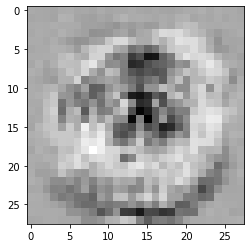

In [32]:
label = 9
targets = np.zeros(output_nodes) + 0.01
targets[label] = 0.99

image_data = n.backquery(targets).cpu().detach().numpy().reshape(28, 28)
plt.imshow(image_data, cmap='Greys', interpolation='None')

In [33]:
n

Classifier(
  (linear_ih): Linear(in_features=784, out_features=200, bias=False)
  (linear_ho): Linear(in_features=200, out_features=10, bias=False)
  (activation): Sigmoid()
  (error_function): MSELoss()
)

In [34]:
n.epochs = 10
n.performance = 0.9823
n.trainging_time = "32 min 38 s"

with open(f'./trained_classifiers/pytorch_tensor_classifiler_{epochs}.pkl', 'wb') as f:
    pickle.dump(n, f)

<matplotlib.image.AxesImage object at 0x7f464971bc70>

<Figure size 432x288 with 1 Axes>

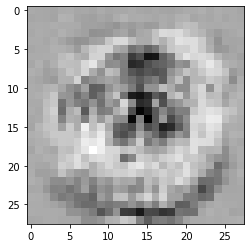

In [35]:
# from pickled object
with open(f'./trained_classifiers/pytorch_tensor_classifiler_{epochs}.pkl', 'rb') as f:
    new_n = pickle.load(f)
    
image_data = new_n.backquery(targets).cpu().detach().numpy().reshape(28, 28)
plt.imshow(image_data, cmap='Greys', interpolation='None')